In [2]:
# Preparations
import os
from PIL import Image
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import scipy
from itertools import compress

from scipy.ndimage import maximum_filter
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import convolve1d as conv1
from scipy.ndimage.filters import convolve as conv2

from skimage.transform import resize, rotate, SimilarityTransform
from skimage.io import imread
from skimage.measure import ransac

from utils import plotFrame, plotFrameBoth, plotImBoth, findNeighbours, plotMatches, geometricVerification

import time

# Select data directory
if os.path.isdir('/coursedata'):
    course_data_dir = '/coursedata'
elif os.path.isdir('../data'):
    course_data_dir = '../data'
else:
    # Specify course_data_dir on your machine
    course_data_dir = '/home/jovyan/work/coursedata/'

print('The data directory is %s' % course_data_dir)
data_dir = os.path.join(course_data_dir, 'exercise-07-data')
print('Data stored in %s' % data_dir)

def getFeatures(imname, postfix=""):
    data = np.load(data_dir+'/data_part1/{}_sift_disc_kps_descrs{}.npy'.format(imname,postfix), encoding='latin1', allow_pickle=True)
    kps = data.item().get('keypoints')
    descrs = data.item().get('descriptors')
    kps = kps.T
    descrs = descrs.T
    return kps, descrs

The data directory is /coursedata
Data stored in /coursedata/exercise-07-data


In [3]:
# Description:
#    Exercise7 VGG practical notebook (stage1, fast track).
#
# This software is inspired by original object instance recognition
# VGG practical. 
# Licence; please refer to the file 
# Licence.txt, included with the software, for details.

# CS-E4850 Computer Vision Exercise Round 7

This is a minimal python version of Oxford Visual Geometry Group's Matlab practical on recognition of object instances
(see the original webpage <a href= http://www.robots.ox.ac.uk/~vgg/practicals/instance-recognition/index.html#part1>here</a>).
By "minimal" it is meant that it uses pre-computed SIFT features and some other needed resources.
All of them are calculated using the freely available matlab scripts found in the practical's github <a href=https://github.com/vedaldi/practical-object-instance-recognition >repository</a>.
The practical is largely based on the vlfeat library (cf. http://www.vlfeat.org/) which unfortunately does not have a Python interface. 
<br><br> 
This notebook is <b>the first part (PART I)</b> of the practical on the so-called  <em> fast track</em> and is about <b>sparse features for matching object instances</b>.
<br><br>
Go through the notebook and answer the questions. You can write your answers to a separate text document and submit that as you are not supposed to implement anything in this exercise.

# Part I: Sparse features for matching object instances
## Stage I.A: SIFT features detector
The SIFT feature has both a detector and a descriptor. We will start by computing and visualizing the SIFT feature detections for two images of the same object (a building facade). Load an image, rotate and scale it, and then display the original and transformed pair:


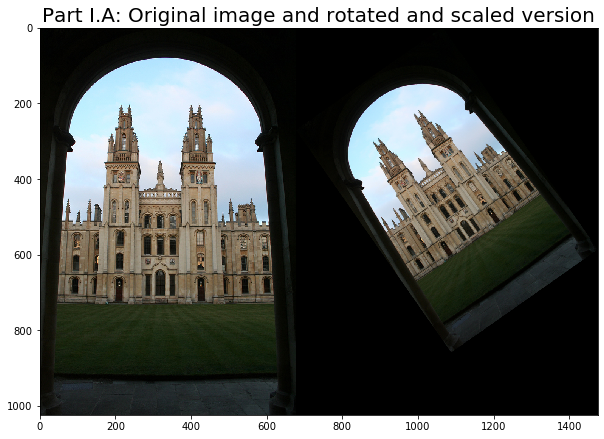

In [4]:
## -------------------------------------------------------------------
#                                   Stage I.A: SIFT features detection
# --------------------------------------------------------------------
# Load an image
im1 = imread(data_dir+'/data/oxbuild_lite/all_souls_000002.jpg') / 255.

# Let the second image be a rotated and scaled version of the first
im3_ = rotate(im1, 35, 'bilinear')
im3_shape = np.round((0.7 * im3_.shape[0], 0.7 * im3_.shape[1]))
im3 = resize(im3_, im3_shape)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,15))
ax.set_title("Part I.A: Original image and rotated and scaled version", fontsize=20)
plotImBoth(ax, im1, im3)

A SIFT frame is a circle with an orientation and is specified by four parameters: the center $t_{x}$, $t_{y}$, the scale $s$, and the rotation $\theta$ (in radians), resulting in a vector of four parameters ($s$,$\theta$,$t_{x}$,$t_{y}$). Now compute and visualise the SIFT feature detections (frames):

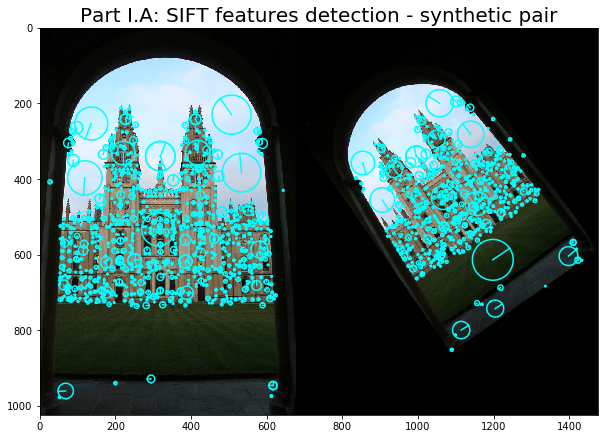

In [5]:
# Compute SIFT features for each (precomputed) 
# In our precomputed features the 'peakThreshold' param is set to 0.01 
# like in the original matlab version
kps1, descrs1 = getFeatures('im1')
kps3, descrs3 = getFeatures('im3rotscaled')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,15))
ax.set_title("Part I.A: SIFT features detection - synthetic pair", fontsize=20)
plotFrameBoth(ax, im1, im3, kps1, kps3, [])
plt.show()

Examine the second image and its rotated and scaled version and convince yourself that the detections overlap the same scene regions (even though the circles have moved their image position and changed radius). You may try to see this better by enlarging the image pair. This demonstrates that the detection process transforms (is co-variant) with translations, rotations and isotropic scalings. This class of transformations is known as a similarity or equiform.

<b>Task</b>: The number of detected features can be controlled by changing the peakThreshold option. A larger value will select features that correspond to higher contrast structures in the image. Try by uncommenting the cell code lines below.

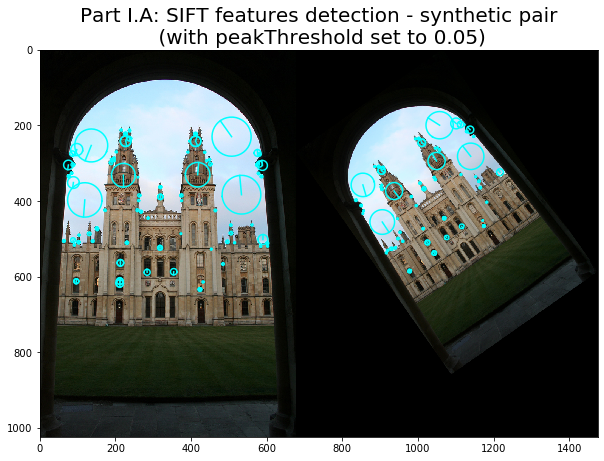

In [6]:
# Compute SIFT features for each (precomputed), set peakThreshold as 0.05
kps1_, descrs1_ = getFeatures('im1','_0_05')
kps3_, descrs3_ = getFeatures('im3rotscaled', '_0_05')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,15))
ax.set_title("Part I.A: SIFT features detection - synthetic pair\n (with peakThreshold set to 0.05)", fontsize=20)
plotFrameBoth(ax, im1, im3, kps1_, kps3_, [])
plt.show()

Now repeat the exercise with a pair of natural images. Start by loading another image. and plot images and feature frames. Again you should see that many of the detections overlap the same scene region. Note that, while repeatability occurs for the pair of natural views, it is much better for the synthetically rotated pair.

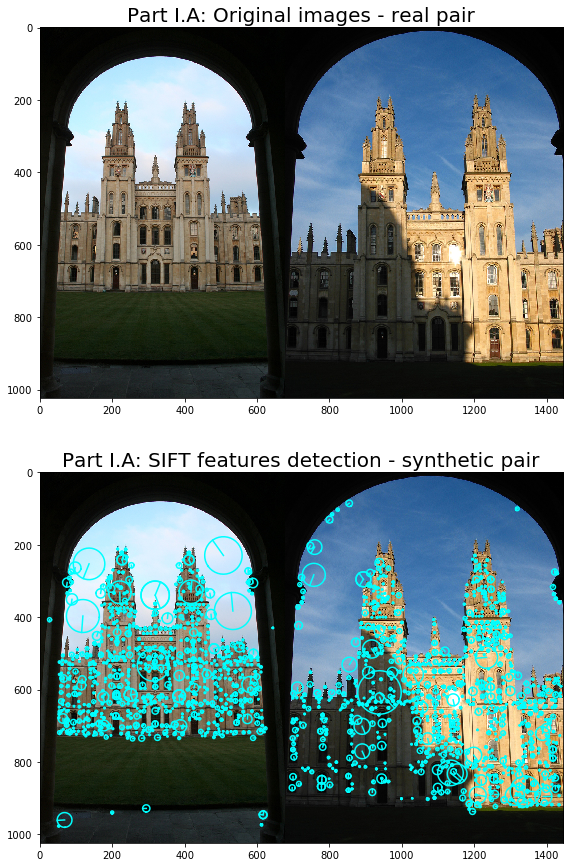

In [7]:
# Load the second image of the same scene
im2 = imread(data_dir+'/data/oxbuild_lite/all_souls_000015.jpg') / 255.

# Compute SIFT features for each (precomputed)
# peakThreshold was 0.01
kps2, descrs2 = getFeatures('im2')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,15))
ax = axes.ravel()
ax[0].set_title("Part I.A: Original images - real pair", fontsize=20)
plotImBoth(ax[0], im1, im2)
ax[1].set_title("Part I.A: SIFT features detection - synthetic pair", fontsize=20)
plotFrameBoth(ax[1], im1, im2, kps1, kps2, [])
plt.show()

<b>Question</b>: Note the change in density of detections across the image. Why does it change? Will it be a problem for matching? How could it be avoided?

<b>Question</b>: Occasionally, a feature is detected multiple times, with different orientations. This may happen when the orientation assignment is ambiguous. Which kind of image structure would result in ambiguous orientation assignment?

## Stage I.B: SIFT features detectors and matching between images
Next we will use the descriptor computed over each detection to match the detections between images. We will start with the simplest matching scheme (first nearest neighbour of descriptors) and then add more sophisticated methods to eliminate any mismatches.

- Visualize the SIFT descriptors for the detected feature frames by plotting the precomputed descriptor frames. Then use plotframe to overlay the corresponding frames.

In [10]:
def getDescriptorFramesAndKeypoints():
    data = np.load(data_dir+'/data_part1/im1_sift_descriptor_xyall_every50th.npy', encoding='latin1', allow_pickle=True)
    xall = data.item().get('xall')
    yall = data.item().get('yall')

    data = np.load(data_dir+'/data_part1/im1_sift_disc_kps_every50th.npy', encoding='latin1', allow_pickle=True)
    kps = data.item().get('keypoints')
    kps = kps.T
    return xall, yall, kps

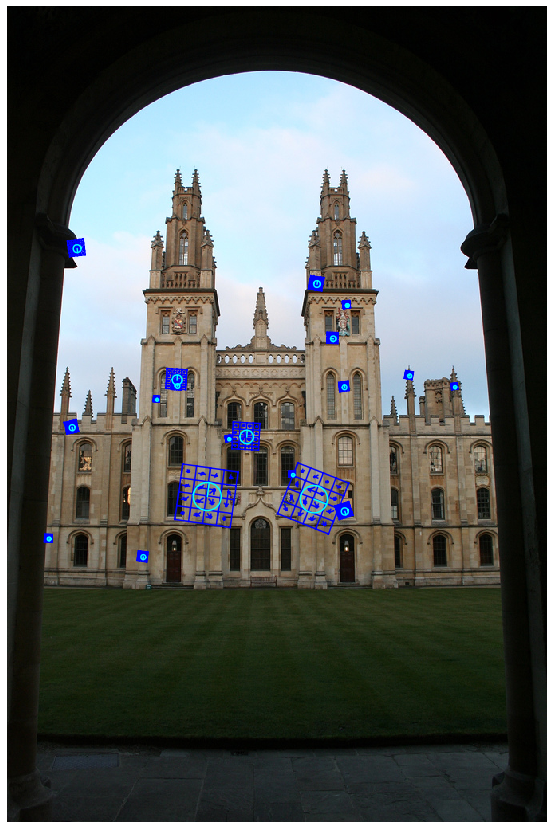

In [11]:
# Visualize SIFT descriptors (only a few)
xall, yall, kps = getDescriptorFramesAndKeypoints()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,15))
# Plot the SIFT descriptor (precomputed) regions of interest for the detected feature frames
ax.plot(xall, yall, color='b')
# Overlay the corresponding frames
plotFrame(ax, im1, kps)
plt.show()

<b>Question</b>: Note the descriptors are computed over a much larger region (shown in blue) than the detection (shown in green). Why?

Hint: Compare the two largest rectangles.

- Compute first nearest neighbours matches - for each SIFT descriptor in the first image, compute its nearest neighbour in the second image with the function findNeighbours.

- Visualize the correspondences using lines joining matched SIFT features with the function plotFrameBoth.


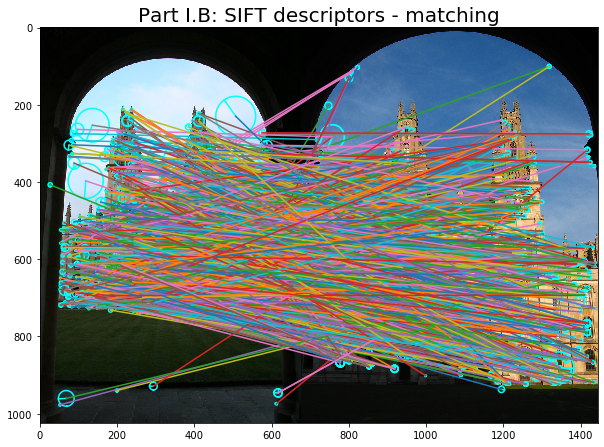

In [12]:
# Compute SIFT features for each (precomputed)
kps2, descrs2 = getFeatures('im2')

# Find for each descriptor in im1 the closest descriptor in im2
# have a look at the findNeighbours in utils.py
ind, dist = findNeighbours(descrs1, descrs2, 1)

matches_raw = np.vstack((np.arange(descrs1.shape[0]), ind))
matches_raw = matches_raw.T

# Display correspondences
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,15))
plotFrameBoth(ax, im1, im2, kps1, kps2, matches_raw, plotMatches=True)
ax.set_title("Part I.B: SIFT descriptors - matching", fontsize=20)
plt.show()

<b>Question</b>: Notice that there are many mismatches. Examine some of the mismatches to understand why the mistakes are being made. For example, is the change in lighting a problem? What additional constraints can be applied to remove the mismatches?

Hint: You can visualize a subset of the matches by uncommenting the lines below:

In [13]:
# Some guidance to the second question ...
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,15))
#plotFrameBoth(ax, im1, im2, kps1, kps2, matches_raw[::20,:], plotMatches=True)
#ax.set_title("Part I.B: SIFT descriptors - matching", fontsize=20)
#plt.show()

## Stage I.C: Improving SIFT matching using Lowe’s second nearest neighbour test
Lowe introduced a second nearest neighbour (2nd NN) test to identify, and hence remove, ambiguous matches. The idea is to identify distinctive matches by a threshold on the ratio of first to second NN distances. In the cell below, the ratio is nnThreshold = 1NN distance / 2NN distance.

- Vary the ratio nnThreshold in a range from 0.1 to 0.9, and examine how the number of matches and number of mismatches changes.
- A value of nnThreshold = 0.8 is often a good compromise between losing too many matches and rejecting mismatches.

<b>Question</b>: Examine some of the remaining mismatches to understand why they have occurred. How could they be removed?


In [ ]:
## -------------------------------------------------------------------
#   Stage I.C: Better matching w/ Lowe's second nearest neighbour test
# --------------------------------------------------------------------

# Find the top two neighbours as well as their distances
ind, dist = findNeighbours(descrs1, descrs2, 2)

# Accept neighbours if their second best match is sufficiently far off
nnThreshold = 0.8
ratio2 = np.divide(dist[:,0], dist[:,1])
ok = ratio2 <= nnThreshold ** 2

# Construct a list of filtered matches
matches_2nn = np.vstack((np.nonzero(ok), ind[ok, 0]))
matches_2nn = matches_2nn.T

# Display the corresponding matches
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,15))
plotFrameBoth(ax, im1, im2, kps1, kps2, matches_2nn, plotMatches=True)
ax.set_title("Part I.C: SIFT descriptors - Lowe's test", fontsize=20)
plt.show()

## Stage I.D: Improving SIFT matching using a geometric transformation
In addition to the 2nd NN test, we can also require consistency between the matches and a geometric transformation between the images. For the moment we will look for matches that are consistent with a similarity transformation

which consists of a rotation by θ, an isotropic scaling (i.e. same in all directions) by s, and a translation by a vector $(t_{x},t_{y})$. This transformation is specified by four parameters $(s,\theta,t_{x},t_{y})$ and can be computed from a single correspondence between SIFT detections in each image.

<b>Task</b>: Work out how to compute this transformation from a single correspondence.
     

Hint: Recall from Stage I.A that a SIFT feature frame is an oriented circle and map one onto the other.

In [ ]:
# Geometric verification
inliers, H = geometricVerification(kps1, kps2, matches_2nn, 8)
matches_geom = matches_2nn[inliers,:]

# Display the matches
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,15))
plotFrameBoth(ax, im1, im2, kps1, kps2, matches_geom, plotMatches=True)
ax.set_title("Part I.C: SIFT descriptors - geometric verification", fontsize=20)
plt.show()

The matches consistent with a similarity can then be found using a RANSAC inspired algorithm, implemented by the function geometricVerification: 

RANSAC-like algorithm for geometric verification

    1. For each tentative correspondence in turn:
        1. compute the similarity transformation;
        2. map all the SIFT detections in one image to the other using this transformation;
        3. accept matches that are within a threshold distance to the mapped detection (inliers);
        4. count the number of accepted matches;
        5. optionally, fit a more accurate affine transformation or homography to the accepted matches and test re-validate the matches.
    2. Choose the transformation with the highest count of inliers.

After this algorithm the inliers are consistent with the transformation and are retained, and most mismatches should now be removed.
